### Generating Image Pairs and Writing to CSV

The code below performs the following tasks:
1. Collects all folder names and image files within each folder from the specified base directory.
2. Creates a CSV file with columns for image paths and labels.
3. Generates false pairs (images from different folders) and writes them to the CSV.
4. Generates true pairs (images from the same folder) and writes them to the CSV.


In [1]:
import os
import csv
import random

# Define the path to the main directory containing the 31 folders
base_path = r'./Images'

# Define the CSV file to be created
csv_file = 'image_data_with_paths.csv'

# Collect all folder names and image files within each folder
folder_images = {}
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        image_files = os.listdir(folder_path)
        if len(image_files) >= 2:
            folder_images[folder] = image_files

# Create a list of folder names for later use in generating False pairs
folder_list = list(folder_images.keys())

# Determine the number of false pairs we can generate, which is based on the number of images in different folders
max_false_pairs = sum(len(files) // 2 for files in folder_images.values())


In [2]:

# Open the CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row with new columns img_1_path, img_2_path, and actual_result
    writer.writerow(['label', 'img-1', 'img-2', 'img_1_path', 'img_2_path', 'actual_result', 'result'])
    
    # Step 1: Generate False pairs (different people)
    false_pairs_count = 0
    while false_pairs_count < max_false_pairs:
        # Randomly select two different folders
        folder_1, folder_2 = random.sample(folder_list, 2)
        
        # Randomly select one image from each folder
        img_1 = random.choice(folder_images[folder_1])
        img_2 = random.choice(folder_images[folder_2])
        
        img_1_path = os.path.join(base_path, folder_1, img_1).replace('\\', '/')
        img_2_path = os.path.join(base_path, folder_2, img_2).replace('\\', '/')
        
        # Write False pair to the CSV (different people)
        writer.writerow([folder_1, img_1, img_2, img_1_path, img_2_path, 'False', ''])
        false_pairs_count += 1

    # Step 2: Generate an equal number of True pairs (same person)
    true_pairs_count = 0
    for folder, image_files in folder_images.items():
        folder_path = os.path.join(base_path, folder)
        
        # Shuffle the images in the folder and pair them
        random.shuffle(image_files)
        for i in range(0, len(image_files) - 1, 2):
            img_1 = image_files[i]
            img_2 = image_files[i + 1]
            
            img_1_path = os.path.join(folder_path, img_1).replace('\\', '/')
            img_2_path = os.path.join(folder_path, img_2).replace('\\', '/')
            
            # Write True pair to the CSV (same person)
            writer.writerow([folder, img_1, img_2, img_1_path, img_2_path, 'True', ''])
            true_pairs_count += 1

            # Stop generating true pairs once we have matched the number of false pairs
            if true_pairs_count >= false_pairs_count:
                break
        if true_pairs_count >= false_pairs_count:
            break

### Data Analysis of Prepared DataSet and Visualization 

The code below performs various data analysis and visualization tasks on the generated CSV file. It includes checking class balance, identifying duplicates, verifying path integrity, performing statistical analysis, and visualizing the pairing of images.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
csv_file = 'image_data_with_paths.csv'
df = pd.read_csv(csv_file)

# Display first few rows of the dataset
df.head()


,label,img-1,img-2,img_1_path,img_2_path,actual_result,result
0,Priyanka Chopra,Priyanka Chopra_12.jpg,Dwayne Johnson_20.jpg,./Images/Priyanka Chopra/Priyanka Chopra_12.jpg,./Images/Dwayne Johnson/Dwayne Johnson_20.jpg,False,NaN
1,Anushka Sharma,Anushka Sharma_14.jpg,Hrithik Roshan_96.jpg,./Images/Anushka Sharma/Anushka Sharma_14.jpg,./Images/Hrithik Roshan/Hrithik Roshan_96.jpg,False,NaN
2,Vijay Deverakonda,Vijay Deverakonda_24.jpg,Brad Pitt_104.jpg,./Images/Vijay Deverakonda/Vijay Deverakonda_2...,./Images/Brad Pitt/Brad Pitt_104.jpg,False,NaN
3,Margot Robbie,Margot Robbie_36.jpg,Tom Cruise_45.jpg,./Images/Margot Robbie/Margot Robbie_36.jpg,./Images/Tom Cruise/Tom Cruise_45.jpg,False,NaN
4,Ellen Degeneres,Ellen Degeneres_47.jpg,Marmik_6.jpg,./Images/Ellen Degeneres/Ellen Degeneres_47.jpg,./Images/Marmik/Marmik_6.jpg,False,NaN


1. Check Class Balance (True vs False)

C:\Users\muhit\AppData\Local\Temp\ipykernel_31504\2012483198.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


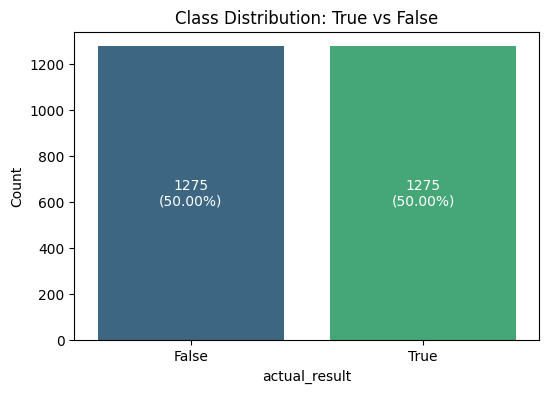

In [4]:
class_distribution = df['actual_result'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution: True vs False')
plt.ylabel('Count')

# Add count and percentage inside each bar
for index, value in enumerate(class_distribution.values):
    percentage = (value / class_distribution.sum()) * 100
    plt.text(index, value / 2, f'{value}\n({percentage:.2f}%)', ha='center', va='center', color='white')

plt.show()


2. Check for Duplicates

In [5]:
duplicate_rows = df[df.duplicated(['img-1', 'img-2'], keep=False)]
print(f"Number of duplicate rows: {len(duplicate_rows)}")


Number of duplicate rows: 0


3. Verify Path Integrity: Check if the image paths exist

In [6]:
def path_exists(row):
    return os.path.exists(row['img_1_path']) and os.path.exists(row['img_2_path'])

df['path_exists'] = df.apply(path_exists, axis=1)
missing_paths = df[~df['path_exists']]
print(f"Number of rows with missing image paths: {len(missing_paths)}")



Number of rows with missing image paths: 0


4. Statistical Analysis: Number of images per folder (label)

C:\Users\muhit\AppData\Local\Temp\ipykernel_31504\3356171902.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=folder_distribution.index, y=folder_distribution.values, palette='coolwarm')


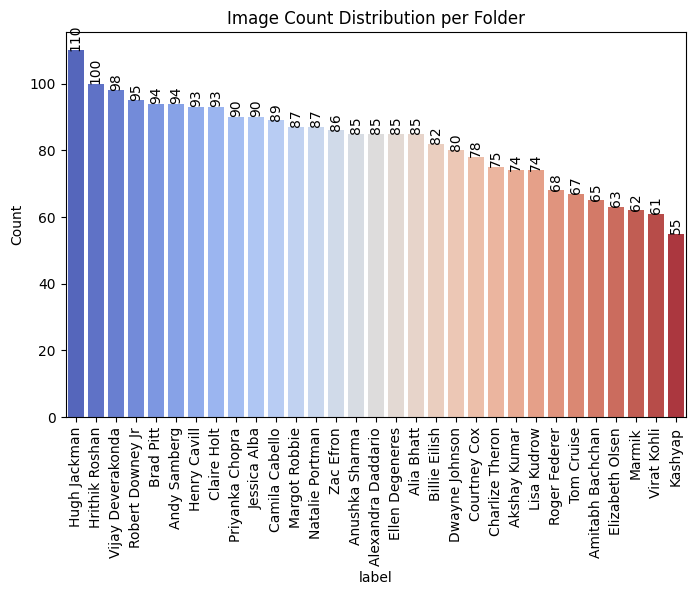

In [7]:
folder_distribution = df['label'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=folder_distribution.index, y=folder_distribution.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Image Count Distribution per Folder')
plt.ylabel('Count')

for index, value in enumerate(folder_distribution.values):
    plt.text(index, value, str(value), ha='center', va='bottom', rotation=90)

plt.show()


5. Summary of findings

In [10]:
# Check for duplicates
duplicate_rows = df[df.duplicated(['img-1', 'img-2'], keep=False)]

print(f"Total rows: {len(df)}")
print(f"Class Balance:\n{class_distribution}")
print(f"Missing image paths: {len(missing_paths)}")
print(f"Duplicate rows: {len(duplicate_rows)}")

Total rows: 2550
Class Balance:
actual_result
False    1275
True     1275
Name: count, dtype: int64
Missing image paths: 0
Duplicate rows: 0
